In [9]:
import torch
import torch.nn as nn
from model.pspnet import PSPNet
import cv2
import numpy as np

def check_data_types(model, input_tensor):
    def forward_hook(module, input, output):
        if len(input) > 0:
            input_type = input[0].dtype
        else:
            input_type = None
        output_type = output.dtype
        print(f"{module.__class__.__name__} - Input type: {input_type}, Output type: {output_type}")
    
    handles = []
    for layer in model.children():
        handle = layer.register_forward_hook(forward_hook)
        handles.append(handle)
    
    model(input_tensor)
    
    for handle in handles:
        handle.remove()

model = PSPNet(num_classes=4, dropout_p=0.5, use_aux=True)
input_a = cv2.imread("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/SEM_DATA/chged_images_256_a50_c80/Image1 - 001_0_0.jpg")
input_b = cv2.imread("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/SEM_DATA/chged_images_256_a50_c80/Image1 - 001_0_4.jpg")
input_n = np.stack((input_a, input_b), axis=0)
input_tensor = torch.tensor(input_n)
input_tensor = input_tensor.permute(0, 3, 1, 2).float()

check_data_types(model, input_tensor)

Sequential - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Dropout2d - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Dropout2d - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Dropout2d - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Dropout2d - Input type: torch.float32, Output type: torch.float32
PSPModule - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32


### 数据长尾程度分析

#### Image

基本统计信息:
直方图区间数: 256
总像素数: 3620864.0
最大频率: 144675.0
最小频率: 0.0
平均频率: 14144.00
频率标准差: 29141.82

分布指标:
基尼系数: 0.7223
熵值: 6.4052
帕累托比例: 0.7747


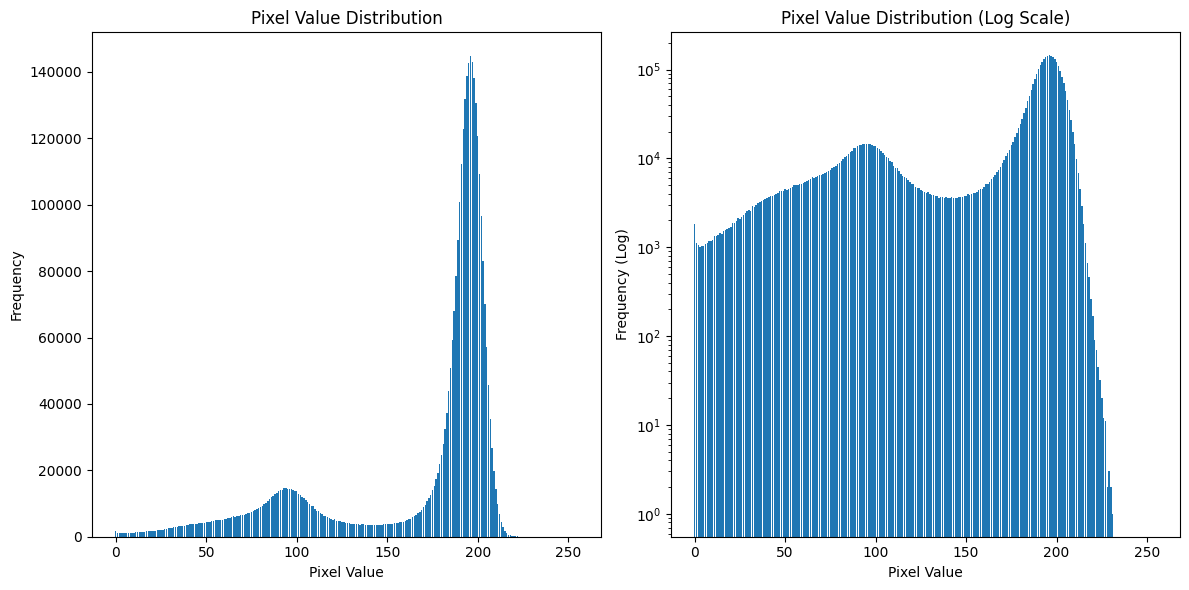

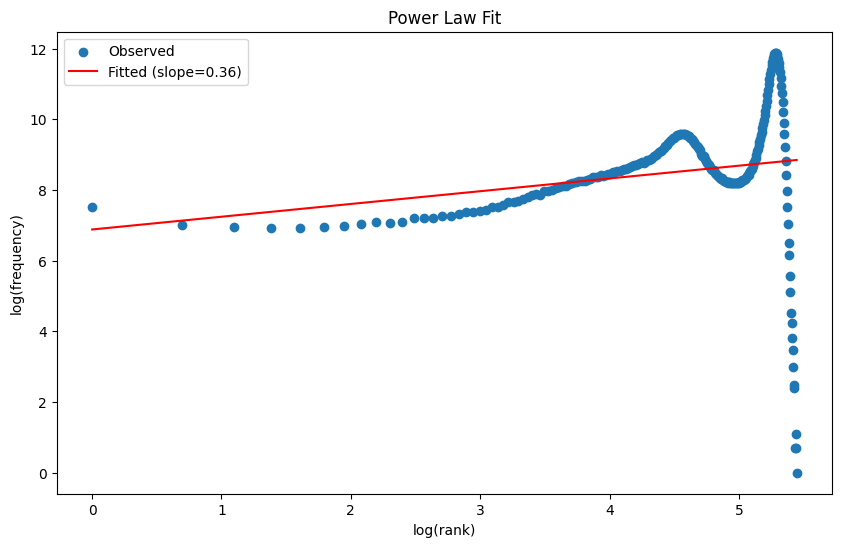


幂律分布拟合结果:
斜率: 0.3609
R²: 0.0354
p值: 0.0040

分位数统计:
10th percentile: 32462.0
25th percentile: 9931.0
50th percentile: 4515.0
75th percentile: 1853.0
90th percentile: 2.0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cv2

def analyze_image_distribution(image):
    """分析图像像素值分布"""
    
    # 确保图像是一维数组
    flattened_image = image.flatten()
    
    # 计算像素值的直方图
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.flatten()
    
    # 1. 基本统计信息
    n_bins = len(hist)
    total_pixels = np.sum(hist)
    
    print("基本统计信息:")
    print(f"直方图区间数: {n_bins}")
    print(f"总像素数: {total_pixels}")
    print(f"最大频率: {np.max(hist)}")
    print(f"最小频率: {np.min(hist)}")
    print(f"平均频率: {np.mean(hist):.2f}")
    print(f"频率标准差: {np.std(hist):.2f}")
    
    # 2. 计算分布指标
    # 基尼系数
    sorted_hist = np.sort(hist)
    cumsum = np.cumsum(sorted_hist)
    gini = (np.sum((2 * np.arange(1, len(hist) + 1) - len(hist) - 1) 
            * sorted_hist)) / (len(hist) * np.sum(sorted_hist))
    
    # 熵值
    probs = hist / total_pixels
    entropy = -np.sum(probs * np.log2(probs + 1e-10))
    
    # 前20%像素值包含的像素比例
    sorted_hist_desc = np.sort(hist)[::-1]
    top_20_percent = int(np.ceil(len(hist) * 0.2))
    pareto_ratio = np.sum(sorted_hist_desc[:top_20_percent]) / total_pixels
    
    print("\n分布指标:")
    print(f"基尼系数: {gini:.4f}")
    print(f"熵值: {entropy:.4f}")
    print(f"帕累托比例: {pareto_ratio:.4f}")
    
    # 3. 绘制分布图
    plt.figure(figsize=(12, 6))
    
    # 基础分布图
    plt.subplot(121)
    plt.bar(range(len(hist)), hist)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # 对数尺度图
    plt.subplot(122)
    plt.bar(range(len(hist)), hist)
    plt.yscale('log')
    plt.title('Pixel Value Distribution (Log Scale)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency (Log)')
    
    plt.tight_layout()
    plt.show()
    
    # 4. 拟合幂律分布
    # 去除零频率
    non_zero_hist = hist[hist > 0]
    x = np.arange(1, len(non_zero_hist) + 1)
    
    # 对数转换
    log_x = np.log(x)
    log_y = np.log(non_zero_hist)
    
    # 线性拟合
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)
    
    # 绘制拟合结果
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x, log_y, label='Observed')
    plt.plot(log_x, slope * log_x + intercept, 'r', 
            label=f'Fitted (slope={slope:.2f})')
    plt.xlabel('log(rank)')
    plt.ylabel('log(frequency)')
    plt.title('Power Law Fit')
    plt.legend()
    plt.show()
    
    print("\n幂律分布拟合结果:")
    print(f"斜率: {slope:.4f}")
    print(f"R²: {r_value**2:.4f}")
    print(f"p值: {p_value:.4f}")
    
    # 5. 分位数统计
    sorted_hist_desc = np.sort(hist)[::-1]
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    print("\n分位数统计:")
    for q in quantiles:
        index = int(len(sorted_hist_desc) * q)
        print(f"{int(q*100)}th percentile: {sorted_hist_desc[index]}")
    
    return {
        'basic_stats': {
            'n_bins': n_bins,
            'total_pixels': total_pixels,
            'max_freq': np.max(hist),
            'min_freq': np.min(hist),
            'mean_freq': np.mean(hist),
            'std_freq': np.std(hist)
        },
        'distribution_metrics': {
            'gini': gini,
            'entropy': entropy,
            'pareto_ratio': pareto_ratio
        },
        'power_law_metrics': {
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value
        }
    }

# 使用示例
image = cv2.imread("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/Image1 - 003.jpeg", cv2.IMREAD_GRAYSCALE)
results = analyze_image_distribution(image)

#### Label

基本统计信息:
类别数量: 4
总样本数: 3620864
最大类别样本数: 2767816
最小类别样本数: 18401
平均每类样本数: 905216.00
样本数标准差: 1104865.60

不平衡指标:
不平衡比率: 150.4166
基尼系数: 0.6075
熵值: 0.9750
帕累托比例: 0.7644


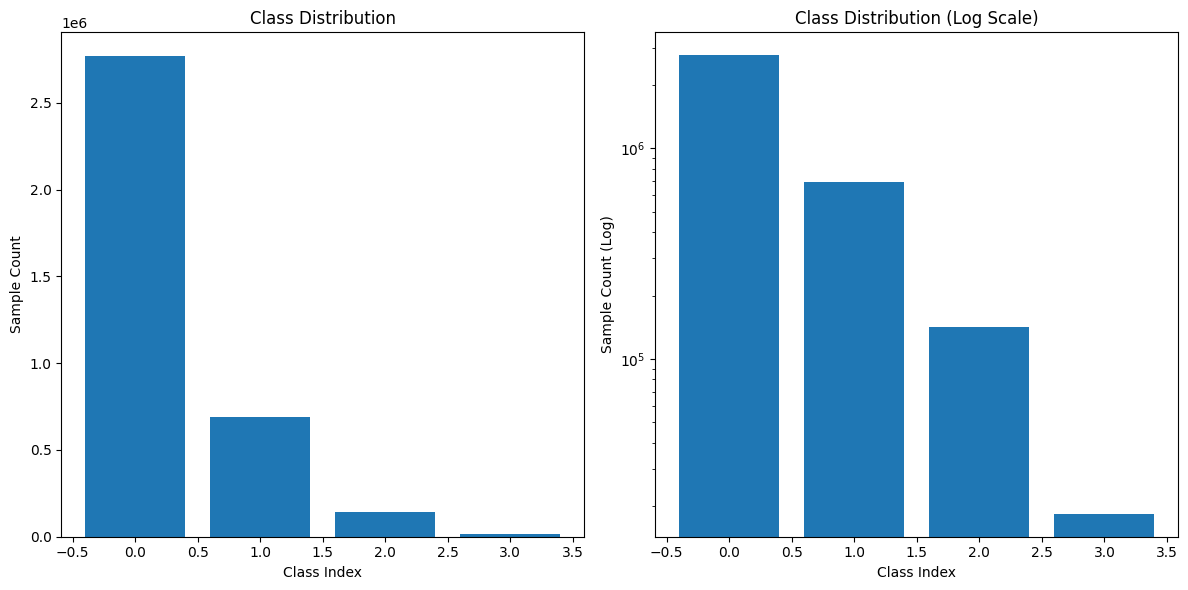

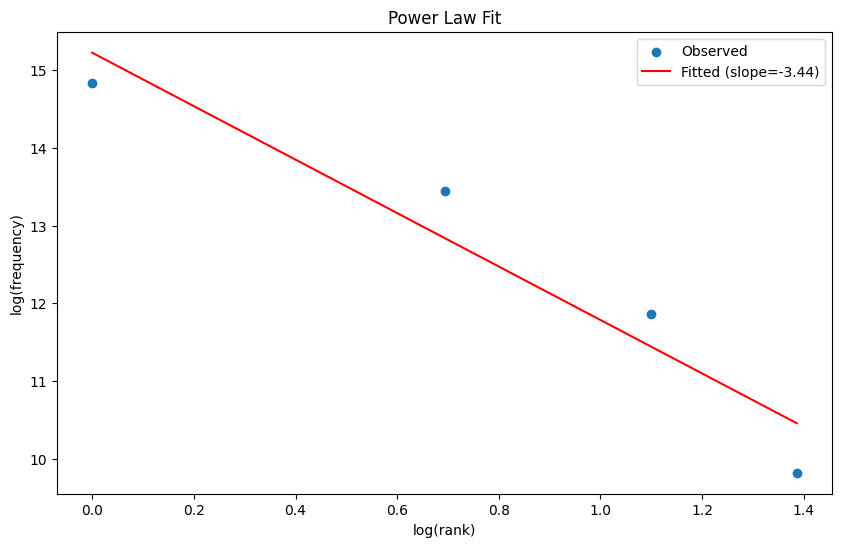


幂律分布拟合结果:
斜率: -3.4390
R²: 0.9208
p值: 0.0404

分位数统计:
10th percentile: 2767816
25th percentile: 692200
50th percentile: 142447
75th percentile: 18401
90th percentile: 18401


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_label_distribution(labels):
    """分析标签分布"""
    
    # 确保标签是一维数组
    labels = np.array(labels).flatten()
    
    # 计算每个类别的样本数量
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    
    # 1. 基本统计信息
    n_classes = len(class_counts)
    
    print("基本统计信息:")
    print(f"类别数量: {n_classes}")
    print(f"总样本数: {total_samples}")
    print(f"最大类别样本数: {np.max(class_counts)}")
    print(f"最小类别样本数: {np.min(class_counts)}")
    print(f"平均每类样本数: {np.mean(class_counts):.2f}")
    print(f"样本数标准差: {np.std(class_counts):.2f}")
    
    # 2. 计算不平衡指标
    # 不平衡比率 (Imbalance Ratio, IR)
    ir = np.max(class_counts) / np.min(class_counts)
    
    # 基尼系数 (Gini Coefficient)
    sorted_counts = np.sort(class_counts)
    cumsum = np.cumsum(sorted_counts)
    gini = (np.sum((2 * np.arange(1, len(class_counts) + 1) - len(class_counts) - 1) 
            * sorted_counts)) / (len(class_counts) * np.sum(sorted_counts))
    
    # 熵值 (Entropy)
    probs = class_counts / total_samples
    entropy = -np.sum(probs * np.log2(probs + 1e-10))
    
    # 类别占比前20%的样本总量占比
    sorted_counts_desc = np.sort(class_counts)[::-1]
    top_20_percent = int(np.ceil(len(class_counts) * 0.2))
    pareto_ratio = np.sum(sorted_counts_desc[:top_20_percent]) / total_samples
    
    print("\n不平衡指标:")
    print(f"不平衡比率: {ir:.4f}")
    print(f"基尼系数: {gini:.4f}")
    print(f"熵值: {entropy:.4f}")
    print(f"帕累托比例: {pareto_ratio:.4f}")
    
    # 3. 绘制分布图
    plt.figure(figsize=(12, 6))
    
    # 基础分布图
    plt.subplot(121)
    plt.bar(range(len(class_counts)), class_counts)
    plt.title('Class Distribution')
    plt.xlabel('Class Index')
    plt.ylabel('Sample Count')
    
    # 对数尺度图
    plt.subplot(122)
    plt.bar(range(len(class_counts)), class_counts)
    plt.yscale('log')
    plt.title('Class Distribution (Log Scale)')
    plt.xlabel('Class Index')
    plt.ylabel('Sample Count (Log)')
    
    plt.tight_layout()
    plt.show()
    
    # 4. 拟合幂律分布
    # 去除零频率
    non_zero_counts = class_counts[class_counts > 0]
    x = np.arange(1, len(non_zero_counts) + 1)
    
    # 对数转换
    log_x = np.log(x)
    log_y = np.log(non_zero_counts)
    
    # 线性拟合
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)
    
    # 绘制拟合结果
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x, log_y, label='Observed')
    plt.plot(log_x, slope * log_x + intercept, 'r', 
            label=f'Fitted (slope={slope:.2f})')
    plt.xlabel('log(rank)')
    plt.ylabel('log(frequency)')
    plt.title('Power Law Fit')
    plt.legend()
    plt.show()
    
    print("\n幂律分布拟合结果:")
    print(f"斜率: {slope:.4f}")
    print(f"R²: {r_value**2:.4f}")
    print(f"p值: {p_value:.4f}")
    
    # 5. 分位数统计
    sorted_counts_desc = np.sort(class_counts)[::-1]
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    print("\n分位数统计:")
    for q in quantiles:
        index = int(len(sorted_counts_desc) * q)
        print(f"{int(q*100)}th percentile: {sorted_counts_desc[index]}")
    
    return {
        'basic_stats': {
            'n_classes': n_classes,
            'total_samples': total_samples,
            'max_samples': np.max(class_counts),
            'min_samples': np.min(class_counts),
            'mean_samples': np.mean(class_counts),
            'std_samples': np.std(class_counts)
        },
        'imbalance_metrics': {
            'imbalance_ratio': ir,
            'gini_coefficient': gini,
            'entropy': entropy,
            'pareto_ratio': pareto_ratio
        },
        'power_law_metrics': {
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value
        }
    }

# 使用示例
labels = cv2.imread("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/Image1 - 003.png", cv2.IMREAD_GRAYSCALE)
results = analyze_label_distribution(labels)

#### 分块预测

In [43]:
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from model.unet import *
from matplotlib import pyplot as plt

def sliding_window(image, window_size, stride):
    """滑动窗口生成器"""
    height, width = image.shape[:2]
    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            yield (x, y, image[y:y+window_size, x:x+window_size])

def merge_predictions(predictions, image_shape, window_size, stride):
    """将预测结果拼接回原始图像尺寸"""
    merged = np.zeros(image_shape, dtype=np.float32)

    index = 0
    for (x, y, window) in sliding_window(predictions, window_size, stride):
        merged[y:y+window_size, x:x+window_size] = predictions[index]
        index += 1
        # plt.imshow(merged)
        # plt.axis('off')
        # plt.show()

    return merged.astype(np.uint8)

# 定义窗口大小和步长
window_size = 256
stride = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image = np.array(Image.open('/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/Image1 - 003.jpeg').convert('RGB'))

# 加载模型
model = MSAF_UNet(in_channels=3, n_classes=4, base_channels=32, bilinear=True, p=0)
model.to(device)

# 加载预训练权重
pretrain_weights = torch.load("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/results/save_weights/msaf_unet/L: DiceLoss--S: CosineAnnealingLR/optim: AdamW-lr: 0.0008-wd: 1e-06/2025-01-16_10:31:49/model_best_ep:14.pth")
if "model" in pretrain_weights:
    model.load_state_dict(pretrain_weights["model"], strict=False)
else:
    model.load_state_dict(pretrain_weights, strict=False)
model.eval()  # 将模型设置为评估模式

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量
])

# 滑窗预测
predictions = []
for (x, y, window) in sliding_window(image, window_size, stride):
    window_tensor = transform(window).unsqueeze(0).to(device)  # 转换为张量并增加 batch 维度
    with torch.no_grad():
        output = model(window_tensor)  # 模型预测
        predicted_window = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # 获取预测类别
    predictions.append(predicted_window)

predictions = np.array(predictions)

# 拼接预测结果
predicted_image = merge_predictions(predictions, image.shape[:2], window_size, stride)

# 保存或显示预测结果
Image.fromarray(predicted_image).save('resunet_a+m.png')
print('预测完成')

/tmp/ipykernel_8450/371500739.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrain_weights = torch.load("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/results/save_weights/

预测完成


In [2]:
import torch
from monai.losses import DiceLoss
import torch.nn.functional as F

# 模拟输入
B, C, H, W = 2, 4, 128, 128
y_pred = torch.randn(B, C, H, W)
y_true = torch.randint(0, C, (B, H, W))

# 不同reduction模式对比
for reduction in ['none', 'mean', 'sum']:
    loss_fn = DiceLoss(include_background=False, 
                      softmax=True, 
                      reduction=reduction)
    loss = loss_fn(y_pred, F.one_hot(y_true, C).permute(0,3,1,2).float())
    print(f"{reduction}:", loss.shape if loss.dim()>0 else loss.item())


none: torch.Size([2, 3, 1, 1])
mean: 0.7488376498222351
sum: 4.493025779724121


In [18]:
x = (1, 2, 3)
y, z = x[0], x[1]
print(y, z)

1 2


In [ ]:
import cv2
import numpy as np
import math
import torch
from torchvision import transforms as T
from model.unet import *
import time
 
# 读取数据
def readimage(path):
    data = cv2.imread(path)
    return data
 
# 保存tif文件函数
def writeTiff(im_data, im_geotrans, im_proj, path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        data = np.array([im_data])
        im_bands, im_height, im_width = data.shape
 
    # 创建文件
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, int(im_width), int(im_height), int(im_bands), datatype)
    if (dataset != None):
        dataset.SetGeoTransform(im_geotrans)  # 写入仿射变换参数
        dataset.SetProjection(im_proj)  # 写入投影
    for i in range(im_bands):
        dataset.GetRasterBand(i + 1).WriteArray(data[i])
    del dataset
 
 
#  tif裁剪（tif像素数据，裁剪边长）
def TifCroppingArray(img, SideLength):
    #  裁剪链表
    TifArrayReturn = []
    #  列上图像块数目
    ColumnNum = int((img.shape[0] - SideLength * 2) / (512 - SideLength * 2))
    #  行上图像块数目
    RowNum = int((img.shape[1] - SideLength * 2) / (512 - SideLength * 2))
    for i in range(ColumnNum):
        TifArray = []
        for j in range(RowNum):
            cropped = img[i * (512 - SideLength * 2): i * (512 - SideLength * 2) + 512,
                      j * (512 - SideLength * 2): j * (512 - SideLength * 2) + 512]
            TifArray.append(cropped)
        TifArrayReturn.append(TifArray)
    #  考虑到行列会有剩余的情况，向前裁剪一行和一列
    #  向前裁剪最后一列
    for i in range(ColumnNum):
        cropped = img[i * (512 - SideLength * 2): i * (512 - SideLength * 2) + 512,
                  (img.shape[1] - 512): img.shape[1]]
        TifArrayReturn[i].append(cropped)
    #  向前裁剪最后一行
    TifArray = []
    for j in range(RowNum):
        cropped = img[(img.shape[0] - 512): img.shape[0],
                  j * (512 - SideLength * 2): j * (512 - SideLength * 2) + 512]
        TifArray.append(cropped)
    #  向前裁剪右下角
    cropped = img[(img.shape[0] - 512): img.shape[0],
              (img.shape[1] - 512): img.shape[1]]
    TifArray.append(cropped)
    TifArrayReturn.append(TifArray)
    #  列上的剩余数
    ColumnOver = (img.shape[0] - SideLength * 2) % (512 - SideLength * 2) + SideLength
    #  行上的剩余数
    RowOver = (img.shape[1] - SideLength * 2) % (512 - SideLength * 2) + SideLength
    return TifArrayReturn, RowOver, ColumnOver
 
#  获得结果矩阵
def Result(shape, TifArray, npyfile, RepetitiveLength, RowOver, ColumnOver):
    result = np.zeros(shape, np.uint8)
    #  j来标记行数
    j = 0
    for i, img in enumerate(npyfile):
        #  最左侧一列特殊考虑，左边的边缘要拼接进去
        if (i % len(TifArray[0]) == 0):
            #  第一行的要再特殊考虑，上边的边缘要考虑进去
            if (j == 0):
                result[0: 512 - RepetitiveLength, 0: 512 - RepetitiveLength] = img[0: 512 - RepetitiveLength,
                                                                               0: 512 - RepetitiveLength]
            #  最后一行的要再特殊考虑，下边的边缘要考虑进去
            elif (j == len(TifArray) - 1):
                #  原来错误的
                # result[shape[0] - ColumnOver : shape[0], 0 : 512 - RepetitiveLength] = img[0 : ColumnOver, 0 : 512 - RepetitiveLength]
                #  后来修改的
                result[shape[0] - ColumnOver - RepetitiveLength: shape[0], 0: 512 - RepetitiveLength] = img[
                                                                                                        512 - ColumnOver - RepetitiveLength: 512,
                                                                                                        0: 512 - RepetitiveLength]
            else:
                result[j * (512 - 2 * RepetitiveLength) + RepetitiveLength: (j + 1) * (
                            512 - 2 * RepetitiveLength) + RepetitiveLength,
                0:512 - RepetitiveLength] = img[RepetitiveLength: 512 - RepetitiveLength, 0: 512 - RepetitiveLength]
                #  最右侧一列特殊考虑，右边的边缘要拼接进去
        elif (i % len(TifArray[0]) == len(TifArray[0]) - 1):
            #  第一行的要再特殊考虑，上边的边缘要考虑进去
            if (j == 0):
                result[0: 512 - RepetitiveLength, shape[1] - RowOver: shape[1]] = img[0: 512 - RepetitiveLength,
                                                                                  512 - RowOver: 512]
            #  最后一行的要再特殊考虑，下边的边缘要考虑进去
            elif (j == len(TifArray) - 1):
                result[shape[0] - ColumnOver: shape[0], shape[1] - RowOver: shape[1]] = img[512 - ColumnOver: 512,
                                                                                        512 - RowOver: 512]
            else:
                result[j * (512 - 2 * RepetitiveLength) + RepetitiveLength: (j + 1) * (
                            512 - 2 * RepetitiveLength) + RepetitiveLength,
                shape[1] - RowOver: shape[1]] = img[RepetitiveLength: 512 - RepetitiveLength, 512 - RowOver: 512]
                #  走完每一行的最右侧，行数+1
            j = j + 1
        #  不是最左侧也不是最右侧的情况
        else:
            #  第一行的要特殊考虑，上边的边缘要考虑进去
            if (j == 0):
                result[0: 512 - RepetitiveLength,
                (i - j * len(TifArray[0])) * (512 - 2 * RepetitiveLength) + RepetitiveLength: (i - j * len(
                    TifArray[0]) + 1) * (512 - 2 * RepetitiveLength) + RepetitiveLength
                ] = img[0: 512 - RepetitiveLength, RepetitiveLength: 512 - RepetitiveLength]
                #  最后一行的要特殊考虑，下边的边缘要考虑进去
            if (j == len(TifArray) - 1):
                result[shape[0] - ColumnOver: shape[0],
                (i - j * len(TifArray[0])) * (512 - 2 * RepetitiveLength) + RepetitiveLength: (i - j * len(
                    TifArray[0]) + 1) * (512 - 2 * RepetitiveLength) + RepetitiveLength
                ] = img[512 - ColumnOver: 512, RepetitiveLength: 512 - RepetitiveLength]
            else:
                result[j * (512 - 2 * RepetitiveLength) + RepetitiveLength: (j + 1) * (
                            512 - 2 * RepetitiveLength) + RepetitiveLength,
                (i - j * len(TifArray[0])) * (512 - 2 * RepetitiveLength) + RepetitiveLength: (i - j * len(
                    TifArray[0]) + 1) * (512 - 2 * RepetitiveLength) + RepetitiveLength,
                ] = img[RepetitiveLength: 512 - RepetitiveLength, RepetitiveLength: 512 - RepetitiveLength]
    return result
 
 
area_perc = 0.6
# 需要被预测的tif文件路径
TifPath = "D:/HHMC/08ORG/wurenji/image/xxxxx.tif"
# 模型路径
model_path = "D:/HHMC/code/unet-pytorch-main/logs/best_epoch_weights_xxxxxxxxxxxx.pth"
 
# 预测结果保存路径
ResultPath = "D:/data/unet/unetprexxxx.tif"
RepetitiveLength = int((1 - math.sqrt(area_perc)) * 512 / 2)
readsttime = time.time()
big_image, geotrans, proj= readTif(TifPath)
readedtime = time.time()
print('读取图像耗时:', {readedtime - readsttime})
big_image = big_image.swapaxes(2, 0).swapaxes(1, 0) # 调整影像维度位置
# print(big_image.shape)
#
# big_image = cv2.imread(TifPath, cv2.IMREAD_UNCHANGED)
 
TifArray, RowOver, ColumnOver = TifCroppingArray(big_image, RepetitiveLength)
 
trfm = T.Compose([
    T.ToTensor(),
])
 
# 改成自己的model即可
model = Unet(num_classes = 2, pretrained = False, backbone = 'resnet50')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #将模型加载到指定设备device上
model.to(device)
cropsttime = time.time()
predicts = []
for i in range(len(TifArray)):
    for j in range(len(TifArray[0])):
        image = TifArray[i][j]
        image = trfm(image)
        print(image.shape)
        image = image.cuda()[None]
        pred = np.zeros((3, 512, 512))
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            # img = image.unsqueeze(0) #  unsqueeze操作为在最外层增加一层维度
            img = image
            print(img.shape)
            out = model(img)
            out = torch.argmax(out,dim=1)
            out = torch.squeeze(out).cpu().numpy()
            pred = out
 
        pred = pred.astype(np.uint8)
        pred = pred.reshape((512, 512))
        predicts.append((pred))
 
# 保存结果predictspredicts
result_shape = (big_image.shape[0], big_image.shape[1])
result_data = Result(result_shape, TifArray, predicts, RepetitiveLength, RowOver, ColumnOver)
cropedtime = time.time()
print('裁剪耗时：', {cropedtime-cropsttime})
writeTiff(result_data, geotrans, proj, ResultPath)
# img = cv2.imread("E:\\forestdata\\justfortest\\outputarea.tif")
# img =(np.maximum(img, 0) / img.max()) * 255
# img = np.uint8(img)
# cv2.imwrite("E:\\forestdata\\justfortest\\outputarea.jpg", img)

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import datetime
import os
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication

class KaoyanAdjustmentScraper:
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        # 设置要爬取的网站列表
        self.sites = [
            {
                'name': '研招网',
                'url': 'https://yz.chsi.com.cn/sytj/tj/listForYzwx.action',
                'parser': self.parse_yz_chsi
            },
            {
                'name': '中国研究生招生信息网',
                'url': 'https://yz.chsi.com.cn/kyzx/tjzd/',
                'parser': self.parse_kyzx_tjzd
            }
            # 可以添加更多网站
        ]
        self.data_path = 'kaoyan_adjustment_data'
        self.create_data_folder()
        
    def create_data_folder(self):
        """创建数据存储文件夹"""
        if not os.path.exists(self.data_path):
            os.makedirs(self.data_path)
    
    def parse_yz_chsi(self, html):
        """解析研招网调剂信息"""
        soup = BeautifulSoup(html, 'html.parser')
        results = []
        
        table = soup.find('table', class_='ch-table')
        if not table:
            return results
            
        rows = table.find_all('tr')
        for row in rows[1:]:  # 跳过表头
            cols = row.find_all('td')
            if len(cols) >= 5:
                university = cols[0].text.strip()
                department = cols[1].text.strip()
                major = cols[2].text.strip()
                requirements = cols[3].text.strip()
                publish_date = cols[4].text.strip()
                url = ""
                link = cols[0].find('a')
                if link and 'href' in link.attrs:
                    url = 'https://yz.chsi.com.cn' + link['href']

In [2]:
from model.msaf_unet import MSAF_UNetv2
model = MSAF_UNetv2(3,4,0)
# 打印各层梯度状态
for name, param in model.named_parameters():
    print(f"{name}: 需要梯度 - {param.requires_grad}")



print(f"dict:{model.state_dict()}")

inconv.conv1.weight: 需要梯度 - True
inconv.conv1.bias: 需要梯度 - True
inconv.bn1.weight: 需要梯度 - True
inconv.bn1.bias: 需要梯度 - True
inconv.conv2.weight: 需要梯度 - True
inconv.conv2.bias: 需要梯度 - True
inconv.bn2.weight: 需要梯度 - True
inconv.bn2.bias: 需要梯度 - True
acpn0.cbrp1.0.dconv.weight: 需要梯度 - True
acpn0.cbrp1.0.dconv.bias: 需要梯度 - True
acpn0.cbrp1.0.pconv.weight: 需要梯度 - True
acpn0.cbrp1.0.pconv.bias: 需要梯度 - True
acpn0.cbrp1.1.weight: 需要梯度 - True
acpn0.cbrp1.1.bias: 需要梯度 - True
acpn0.cbrp2.0.dconv.weight: 需要梯度 - True
acpn0.cbrp2.0.dconv.bias: 需要梯度 - True
acpn0.cbrp2.0.pconv.weight: 需要梯度 - True
acpn0.cbrp2.0.pconv.bias: 需要梯度 - True
acpn0.cbrp2.1.weight: 需要梯度 - True
acpn0.cbrp2.1.bias: 需要梯度 - True
acpn0.cbrp2.3.dconv.weight: 需要梯度 - True
acpn0.cbrp2.3.dconv.bias: 需要梯度 - True
acpn0.cbrp2.3.pconv.weight: 需要梯度 - True
acpn0.cbrp2.3.pconv.bias: 需要梯度 - True
acpn0.cbrp2.4.weight: 需要梯度 - True
acpn0.cbrp2.4.bias: 需要梯度 - True
acpn0.cbrp3.0.dconv.weight: 需要梯度 - True
acpn0.cbrp3.0.dconv.bias: 需要梯度 - True
acpn0.cb